## jupyter notebook for testing Main2.py and MM functions

Author: Eric Wu <br>
Date: 11.11.2025

## Contents
0. [Import Dependencies](#0-import-dependencies)
1. [Initialize Realm](#1-initialize-realm)
2. [Check Location Generation](#2-check-location-generation)
3. [Run EvolveMM](#3-run-evolvemm)
    - [mm_employee_master Delta Report](#31-evolvemm-with-an-interupt-to-check-mm_employee_master-deltas)
4. [Check Outputs](#4-check-outputs)

### 0. Import Dependencies

In [1]:
import numpy as np 
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 100)
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
mydir = '/Users/eric/Documents/CDS465/' ### ADJUST FILEPATH

pysrc = mydir + 'pysrc/'
datadir = mydir + 'data/'
popdir = mydir + 'population/'
folderpath = mydir + 'archieve/Dev_P1/BASE_DATA/' ###set folderpath

sys.path.append( pysrc )
import Main2
import island

import initialization as initf
import operations as ops

### 1. Initialize Realm

In [3]:
E = Main2.Realm(datadir)
E.ReadAll(popdir + 'pop3_7.db') ### ADJUST NAME
E.loc_gen_dict = {'farming': (5,12,5),'mining': (5,16,10),'energy': (0,50,20),'manufacturing': (5,100,50)} #set params
E.folderpath = folderpath #set params
E.InitializeMM()
#E.initfQuickLook(5)

Population started at 8320. 
Need to evolve 8 months before initialization for parity with accounting periods. 
initializing...


### 2. Check Location Generation

Should have 15 locations: (5 farms, 5 mines, and 5 manufacturing plants)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


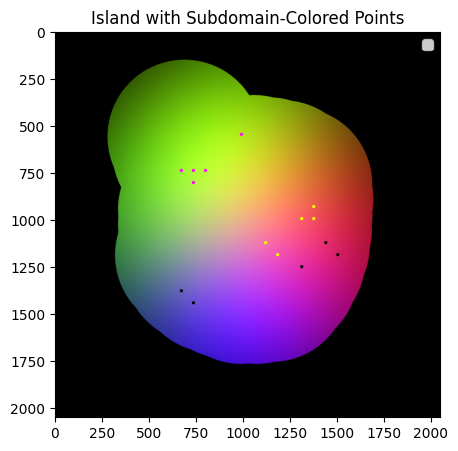

In [4]:
island_raw = E.isle['raw']

color_map = {
    'farming': [255, 0, 50],     #magenta
    'mining': [255, 255, 0],      #yellow
    'manufacturing': [0, 0, 0] #black
}

pixel_size = 15
half_size = pixel_size // 2

for index, row in E.mm_dfs['mm_location_master'].iterrows():
    #get coordinates and subdomain
    location_coord = row['location_coord']
    subdomain = row['subdomain']
    
    #get centers
    y_center, x_center = location_coord
    y_center, x_center = int(y_center), int(x_center)
    
    #pixel "shape + size"
    y_start = max(0, y_center - half_size)
    y_end = min(2048, y_center + half_size + 1)
    x_start = max(0, x_center - half_size)
    x_end = min(2048, x_center + half_size + 1)

    #apply color
    island_raw[y_start:y_end, x_start:x_end] = color_map[subdomain]

plt.figure(figsize=(5, 5))
plt.imshow(island_raw)
plt.title("Island with Subdomain-Colored Points")
plt.legend()
plt.show()

### 3. Run EvolveMM

In [5]:
#EvolveMM(Nmonths, addpeep, dometh, migrate=False)
E.mm_params['n_orders'] = 100
E.mm_params['xbar_order_size'] = 250


t_b = time.perf_counter()
nmonths = 12*4
E.EvolveMM(nmonths,5,0,False)
t_e = time.perf_counter()

print(f'Total time for evolving {nmonths} months was {(t_e-t_b):.4f} seconds')

Total added time due to operations was 5.103701204963727 seconds. 
Total time due to Evolve was 54.35120616614586 seconds.
Total time for evolving 48 months was 59.4561 seconds


#### 3.1 EvolveMM with an interupt to check mm_employee_master Deltas

In [5]:
def create_delta_report(df_old: pd.DataFrame, df_new: pd.DataFrame, key_column: str) -> pd.DataFrame:
    """
    Compares two DataFrames to create a delta report showing added, deleted,
    and modified rows.
    """
    # Set the unique key as the index for alignment
    df_old_indexed = df_old.set_index(key_column).sort_index()
    df_new_indexed = df_new.set_index(key_column).sort_index()

    # Get indices of rows only in the new DF (Added)
    added_index = df_new_indexed.index.difference(df_old_indexed.index)
    df_added = df_new_indexed.loc[added_index].copy()
    df_added['Change_Type'] = 'Added'

    # Get indices of rows only in the old DF (Deleted)
    deleted_index = df_old_indexed.index.difference(df_new_indexed.index)
    df_deleted = df_old_indexed.loc[deleted_index].copy()
    df_deleted['Change_Type'] = 'Deleted'
    
    # Get indices of rows present in both (Common)
    common_index = df_new_indexed.index.intersection(df_old_indexed.index)
    df_common_old = df_old_indexed.loc[common_index]
    df_common_new = df_new_indexed.loc[common_index]

    # Use .compare() to find differences in common rows
    # Keep only rows where a difference was found (i.e., drop rows with all NaN columns)
    df_modified = df_common_old.compare(df_common_new, align_axis=1, result_names=('Old', 'New'))
    df_modified = df_modified.dropna(axis=0, how='all')
    
    if not df_modified.empty:
        # Flatten the MultiIndex columns and add a Change_Type column
        # Example: ('Price', 'Old') becomes 'Price_Old'
        df_modified.columns = [f'{col[0]}_{col[1]}' for col in df_modified.columns]
        df_modified['Change_Type'] = 'Modified'
        
        # Bring the 'Modified' change type column to the front
        cols = ['Change_Type'] + [col for col in df_modified.columns if col != 'Change_Type']
        df_modified = df_modified[cols]
    
    # Align columns for added/deleted before concatenation
    all_reports = [df_added, df_deleted]
    
    # Only include modified if there are actual changes
    if not df_modified.empty:
        all_reports.append(df_modified.reset_index(names=key_column))
    
    # For a clean final view, stack the added and deleted reports first
    final_report = pd.concat(all_reports, ignore_index=False)
    
    # For Added/Deleted rows, move the key column from index to a regular column
    df_added_deleted = final_report[final_report['Change_Type'].isin(['Added', 'Deleted'])].reset_index(names=key_column)
    
    # Combine the Added/Deleted and Modified results
    df_final = pd.concat([df_added_deleted, df_modified.reset_index(names=key_column)[df_modified.columns.insert(0, key_column)]], ignore_index=True)
    
    # Sort the results by the key column and change type
    df_final = df_final.sort_values(by=[key_column, 'Change_Type']).reset_index(drop=True)
    
    return df_final

In [6]:
#EvolveMM(Nmonths, addpeep, dometh, migrate=False)
E.mm_params['n_orders'] = 100
E.mm_params['xbar_order_size'] = 250

nmonths = 12*50
t_b = time.perf_counter()
for month in range(nmonths):
    emp_old = E.mm_dfs['mm_employee_master'].copy()
    E.EvolveMM(1,5,0,False)
    emp_new = E.mm_dfs['mm_employee_master'].copy()
    
    print(f'At month {E.month} the deltas in employee master are')
    print(create_delta_report(emp_old, emp_new,'pid'))
    
t_e = time.perf_counter()
print(f'Total time for evolving {nmonths} months was {(t_e-t_b):.4f} seconds')

Total added time due to operations was 0.08542645801207982 seconds. 
Total time due to Evolve was 1.1894871660042554 seconds.
       pid   location_coord     wage Change_Type  (pid, )
0 73899.00  (1376.0, 736.0) 50000.00     Deleted      NaN
1 74629.00  (736.0, 1504.0) 50000.00     Deleted      NaN
2 75023.00  (1376.0, 736.0) 50000.00       Added      NaN
3 79866.00  (736.0, 1504.0) 50000.00       Added      NaN
Total added time due to operations was 0.08234887500293553 seconds. 
Total time due to Evolve was 1.1051965829974506 seconds.
       pid    location_coord     wage Change_Type  (pid, )
0 68752.00   (736.0, 1504.0) 50000.00     Deleted      NaN
1 74217.00  (1184.0, 1440.0) 50000.00     Deleted      NaN
2 79838.00  (1184.0, 1440.0) 50000.00       Added      NaN
3 80092.00   (736.0, 1504.0) 50000.00       Added      NaN
Total added time due to operations was 0.08004195801913738 seconds. 
Total time due to Evolve was 1.0684663330030162 seconds.
       pid    location_coord     wage

### 4. Check outputs

In [16]:
E.mm_dfs['mm_order_master'].groupby('order_date')['order_id'].count().reset_index().tail()

,order_date,order_id
43,8371,100
44,8372,100
45,8373,100
46,8374,100
47,8375,100


In [32]:
print(
((sum(E.mm_dfs['mm_order_master']['account_receivable']) - 48*325*50000/12)*.78 *.9),
sum(E.mm_dfs['mm_location_master']['balance']),
sum(E.mm_dfs['mm_books']['period_income']),
sum(E.mm_dfs['mm_location_master']['balance']) + sum(E.mm_dfs['mm_books']['period_income']),
sum(E.mm_dfs['mm_books']['balance_e']) - sum(E.mm_dfs['mm_books']['balance_s'])
)

142733184.048 3068125.214243306 118574047.75312944 121642172.96737275 98850855.8505525


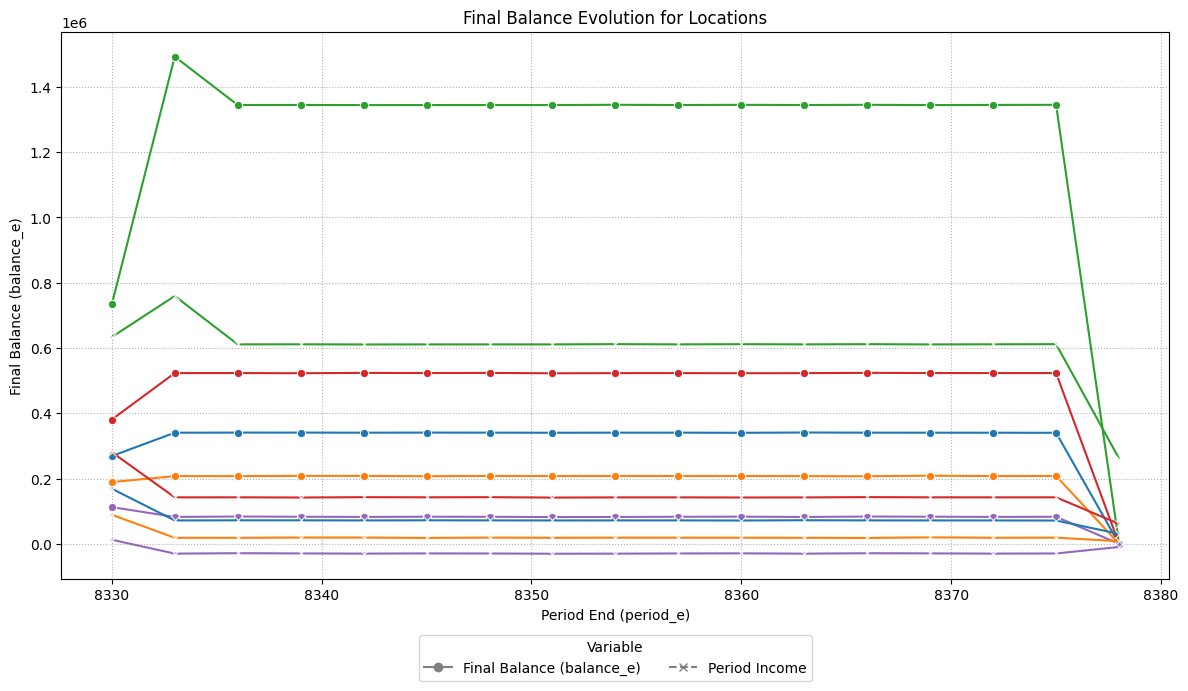

In [11]:
df_books = E.mm_dfs['mm_books'].copy()

# Select a few locations to keep the plot readable (e.g., the top 5 by latest balance)
latest_period = df_books['period_e'].max()
top_locations = df_books[df_books['period_e'] == latest_period].nlargest(5, 'balance_e')['location_coord']

df_tracking = df_books[df_books['location_coord'].isin(top_locations)]

plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_tracking,
    x='period_e',
    y='balance_e',
    hue='location_coord',
    marker='o'
)
sns.lineplot(
    data=df_tracking,
    x='period_e',
    y='period_income',
    hue='location_coord',
    marker='x'
)
legend_handles = [
    plt.Line2D([0], [0], color='gray', linestyle='-', marker='o', label='Final Balance (balance_e)'),
    plt.Line2D([0], [0], color='gray', linestyle='--', marker='x', label='Period Income')
]
plt.legend(handles=legend_handles, title='Variable', loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)

plt.yscale('linear')
plt.title('Final Balance Evolution for Locations')
plt.xlabel('Period End (period_e)')
plt.ylabel('Final Balance (balance_e)')
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()

In [24]:
def plot_balance_by_period(df, top_n=10, num_periods_to_show=4):
    """
    Generates a separate bar plot for the final balance for the top N locations
    for the last 'num_periods_to_show' unique periods.
    """
    # Find the unique periods and select the latest ones
    unique_periods = df['period_e'].sort_values(ascending=True).unique()
    periods_to_plot = unique_periods[-num_periods_to_show:]

    # Determine the number of rows and columns for the subplot grid
    # Use 2 columns max for better readability
    n_cols = min(len(periods_to_plot), 2)
    n_rows = (len(periods_to_plot) + n_cols - 1) // n_cols

    # Create the figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 4 * n_rows))
    
    # Ensure axes is always iterable
    if n_rows * n_cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, period in enumerate(periods_to_plot):
        # Filter data for the current period
        df_period = df[df['period_e'] == period].copy()

        # Convert location_coord to string to avoid ValueError
        df_period['location_coord'] = df_period['location_coord'].astype(str)

        # Sort and select top N locations based on balance_e
        df_period_sorted = df_period.nlargest(top_n, 'balance_e')

        # Use the current axis
        ax = axes[i]

        # Generate the bar plot
        sns.barplot(
            x='balance_e',
            y='location_coord',
            data=df_period_sorted,
            palette='viridis',
            ax=ax
        )

        ax.set_title(f'Period End: {period} (Top {top_n} Locations)', fontsize=14)
        ax.set_xlabel('Final Balance ($)')
        #ax.ticklabel_format(style='plain', axis='y', useOffset=False)
        #ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=6, prune='lower'))
        ax.set_ylabel('Location Coordinates')
        # Display large numbers cleanly without scientific notation
        ax.ticklabel_format(style='plain', axis='x', useOffset=False)
        ax.xaxis.grid(True, linestyle='--')

    # Remove any unused subplots
    for j in range(len(periods_to_plot), n_rows * n_cols):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# You would call this function with your DataFrame:
#plot_balance_by_period(E.mm_dfs['mm_books'], top_n=15, num_periods_to_show=10)

In [25]:
E.mm_dfs['mm_employee_master'].groupby('location_coord')['pid'].count().reset_index()

,location_coord,pid
0,"(544.0, 992.0)",5
1,"(736.0, 672.0)",5
2,"(736.0, 736.0)",5
3,"(736.0, 800.0)",5
4,"(800.0, 736.0)",5
5,"(928.0, 1376.0)",10
6,"(992.0, 1312.0)",10
7,"(992.0, 1376.0)",10
8,"(1120.0, 1120.0)",10
9,"(1120.0, 1440.0)",50


In [26]:
E.mm_dfs['mm_books'].tail(60)

,location_coord,period_s,period_e,balance_s,balance_e,period_income,sales_tax
195,"(736.0, 800.0)",8367,8369,268845.83,340458.01,71612.17,0.00
196,"(736.0, 672.0)",8367,8369,189054.63,208718.61,19663.98,0.00
197,"(800.0, 736.0)",8367,8369,733530.11,1344516.13,610986.03,0.00
198,"(544.0, 992.0)",8367,8369,380851.63,523292.33,142440.70,0.00
199,"(736.0, 736.0)",8367,8369,112430.56,83069.84,-29360.72,0.00
200,"(1184.0, 1184.0)",8367,8369,3371514.66,5978877.72,2607363.06,0.00
201,"(992.0, 1376.0)",8367,8369,1347965.66,2542223.69,1194258.03,0.00
202,"(1120.0, 1120.0)",8367,8369,860827.16,1186657.31,325830.15,0.00
203,"(928.0, 1376.0)",8367,8369,2138919.59,3603491.35,1464571.76,0.00
204,"(992.0, 1312.0)",8367,8369,570519.26,565731.87,-4787.39,0.00


In [27]:
E.month

8376

In [28]:
E.mm_dfs['mm_order_master'].loc[E.mm_dfs['mm_order_master']['order_status'] > 0]

,order_id,product_id,product_quantity,order_date,ship_to,ship_by,account_receivable,order_status
4765,o004766,p000113,296,8374,qa_simulate_orders,8377,118400.00,1
4787,o004788,p000113,308,8374,qa_simulate_orders,8377,123200.00,1
4806,o004807,p000125,258,8374,qa_simulate_orders,8377,258000.00,1
4814,o004815,p000101,228,8374,qa_simulate_orders,8377,273600.00,1
4825,o004826,p000113,242,8374,qa_simulate_orders,8377,96800.00,1
4851,o004852,p000116,270,8375,qa_simulate_orders,8377,121500.00,1
4852,o004853,p000319,240,8375,qa_simulate_orders,8377,144000.00,1
4855,o004856,p000322,277,8375,qa_simulate_orders,8377,207750.00,1
4861,o004862,p000122,280,8375,qa_simulate_orders,8377,140000.00,1
4865,o004866,p000113,296,8375,qa_simulate_orders,8378,118400.00,2


In [29]:
E.mm_dfs['mm_location_master']

,location_coord,domain,subdomain,location_energy,required_personelle_num,required_personelle_types,manufacture_capacity,balance
0,"(736.0, 800.0)",resource,farming,-1,5,NaN,0,30555.26
1,"(736.0, 672.0)",resource,farming,-1,5,NaN,0,8004.05
2,"(800.0, 736.0)",resource,farming,-1,5,NaN,0,261330.52
3,"(544.0, 992.0)",resource,farming,-1,5,NaN,0,60924.18
4,"(736.0, 736.0)",resource,farming,-1,5,NaN,0,-9781.49
5,"(1184.0, 1184.0)",resource,mining,-1,10,NaN,0,1114975.76
6,"(992.0, 1376.0)",resource,mining,-1,10,NaN,0,510415.33
7,"(1120.0, 1120.0)",resource,mining,-1,10,NaN,0,139981.93
8,"(928.0, 1376.0)",resource,mining,-1,10,NaN,0,626106.81
9,"(992.0, 1312.0)",resource,mining,-1,10,NaN,0,-2516.67
